<h1><h1>Concrete Crack Classification</h1>


The dataset includes 40,000 sample photos of concrete. Half of them have cracks and the other half do not. This project aims to create a PyTorch model that can classify photos of cracked concrete.

<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files.

In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

In [ ]:
!unzip -q Positive_tensors.zip 

In [ ]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

Install torchvision:

In [ ]:
!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


In [1]:
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


In [4]:
class Dataset(Dataset):

    #constructor
    def __init__(self,transform=None,train=True):
        directory = "/home/wsuser/work"
        positive = "Positive_tensors"
        negative = 'Negative_tensors'

        positive_file_path = os.path.join(directory,positive)
        negative_file_path = os.path.join(directory,negative)
        positive_files = [os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files = [os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples = len(positive_files)+len(negative_files)
        self.all_files = [None]*number_of_samples
        self.all_files[::2] = positive_files
        self.all_files[1::2] = negative_files 
        #transform going to be used on image
        self.transform = transform
        self.Y = torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2] = 1
        self.Y[1::2] = 0
        
        if train:
            self.all_files = self.all_files[0:30000]
            self.Y = self.Y[0:30000]
            self.len = len(self.all_files)
        else:
            self.all_files = self.all_files[30000:]
            self.Y = self.Y[30000:]
            self.len = len(self.all_files)     
       
    #get length
    def __len__(self):
        return self.len
    
    #getter
    def __getitem__(self, idx):
               
        image = torch.load(self.all_files[idx])
        y = self.Y[idx]
                  
        #if there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


Two dataset objects, one for the training data and one for the validation data.


In [5]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true.

In [6]:
resnet18 = models.resnet18(pretrained=True)

Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.

In [7]:
for param in resnet18.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


I will replace the output layer <code>resnet18.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes.

In [8]:
resnet18.fc = nn.Linear(512, 2)

Print out the model.

In [9]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Train the model.

We first create a cross entropy criterion function.

In [10]:
criterion = nn.CrossEntropyLoss()

Now creates a training loader and validation loader object with batch size of 100 samples each.

In [11]:
train_loader = DataLoader(dataset = train_dataset,batch_size = 100)
validation_loader = DataLoader(dataset = validation_dataset,batch_size = 100)

The following is the optimizer used to minimize the loss.

In [13]:
optimizer = torch.optim.Adam([parameters  for parameters in resnet18.parameters() if parameters.requires_grad],lr=0.001)

Calculates the accuracy for one epoch.

In [14]:
n_epochs = 1
loss_list = []
accuracy_list = []
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        resnet18.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        yhat = resnet18(x)
        #calculate loss 
        loss = criterion(yhat,y)
        #calculate gradients of parameters 
        loss.backward()
        #update parameters 
        optimizer.step()
        loss_list.append(loss.data)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


In [15]:
for x_test, y_test in validation_loader:
    #set model to eval 
    resnet18.eval()
    #make a prediction 
    z = resnet18(x_test)
    #find max 
    _, yhat = torch.max(z.data, 1)
       
    #calculate misclassified  samples in mini-batch 
    correct += (yhat == y_test).sum().item()
   
accuracy = correct/N_test

Print accuracy

In [16]:
accuracy

0.9948

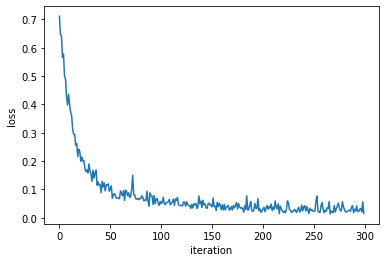

In [17]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

Identifying the first 4 misclassified samples.

In [18]:
c = 0
sample = 0
Softmax_fn = nn.Softmax(dim=-1)
validation_loader = DataLoader(dataset = validation_dataset,batch_size = 1)
for x, y in validation_loader:
    sample = sample + 1
    z = resnet18(x)
    _, yhat = torch.max(z, 1)
    correct = (yhat == y)
    if correct == 0 :
        print("sample {} predicted_value : {} actual_value :{}".format(sample,yhat[0].data,y[0].data))
        c += 1
    if c >= 4:
        break            

sample 97 predicted_value : 0 actual_value :1
sample 369 predicted_value : 0 actual_value :1
sample 398 predicted_value : 1 actual_value :0
sample 543 predicted_value : 0 actual_value :1
